# 模型训练

五维判断：x是一个5维向量，输出极小值坐标

epoch: 1, loss: 1.634430
correct: 40, rate: 0.400000
epoch: 2, loss: 1.504482
correct: 57, rate: 0.570000
epoch: 3, loss: 1.412432
correct: 68, rate: 0.680000
epoch: 4, loss: 1.333481
correct: 74, rate: 0.740000
epoch: 5, loss: 1.262503
correct: 86, rate: 0.860000
epoch: 6, loss: 1.198015
correct: 88, rate: 0.880000
epoch: 7, loss: 1.139214
correct: 89, rate: 0.890000
epoch: 8, loss: 1.085482
correct: 84, rate: 0.840000
epoch: 9, loss: 1.036285
correct: 90, rate: 0.900000
epoch: 10, loss: 0.991151
correct: 94, rate: 0.940000
epoch: 11, loss: 0.949660
correct: 93, rate: 0.930000
epoch: 12, loss: 0.911437
correct: 90, rate: 0.900000
epoch: 13, loss: 0.876148
correct: 95, rate: 0.950000
epoch: 14, loss: 0.843498
correct: 91, rate: 0.910000
epoch: 15, loss: 0.813226
correct: 96, rate: 0.960000
epoch: 16, loss: 0.785100
correct: 95, rate: 0.950000
epoch: 17, loss: 0.758915
correct: 91, rate: 0.910000
epoch: 18, loss: 0.734491
correct: 92, rate: 0.920000
epoch: 19, loss: 0.711666
correct: 97

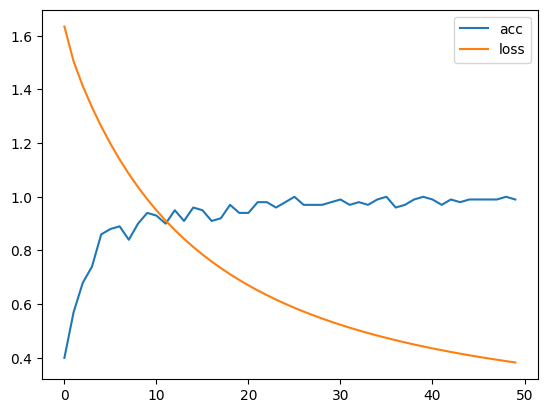

In [10]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 定义TorchModelDemo的类，继承nn.Module（pytorch中定义神经网络模型的基类）
class TorchModelDemo(nn.Module):
    # 初始化方法，定义模型的结构和参数，input_size是输入特征的大小
    def __init__(self, input_size):
        # 调用父类的的初始化方法
        super(TorchModelDemo, self).__init__()
        # 定义一个线性层（全连接层，输入大小为input_size, 输出大小为5）
        self.linear = nn.Linear(input_size, 5) # 线性层
        # 定义损失函数
        self.loss = nn.functional.cross_entropy # 问题： 为何采用交叉熵损失
    
    # y 真实标签数据
    def forward(self, x, y=None):
        # 输入x通过线性层进行线性变换，得到输出x的预测结果
        y_pred = self.linear(x)
        if y is not None:
            return self.loss(y_pred, y)  # 预测值和真实值计算损失
        else:
            return y_pred  # 输出预测结果

        
def build_sample():
    x = np.random.random(5)
    min_index = np.argmin(x)
    if min_index == 0:
        return x, 0
    elif min_index == 1:
        return x, 1
    elif min_index == 2:
        return x, 2
    elif min_index == 3:
        return x, 3
    else:
        return x, 4
    
def build_dataset(total_sample_num):
    X = []
    Y = []
    for i in range(total_sample_num):
        x, y = build_sample()
        X.append(x)
        Y.append(y)
    return torch.FloatTensor(X), torch.LongTensor(Y)

def evaluate(model):
    # 将模型设置为评估模式
    model.eval()
    test_sample_num = 100
    x, y = build_dataset(test_sample_num)
    correct, wrong = 0, 0
    # 使用torch.no_grad()上下文管理器，禁用梯度计算，在评估过程中，不需要计算梯度，因此可以通过使用torch.no_grad()来提高运行效率
    with torch.no_grad():
        y_pred = model(x)
        for y_p, y_t in zip(y_pred, y):
            # print("y_p:", y_p, "y_t:", y_t)
            if torch.argmax(y_p) == int(y_t):
                correct += 1
            else:
                wrong += 1
    print("correct: %d, rate: %f" % (correct, correct / (correct + wrong)))
    return correct / (correct + wrong)
    
def train():
    # 训练轮数是指将整个训练数据集在模型上迭代的次数。选择训练轮数时，通常需要考虑模型在训练数据上的表现和收敛情况。如果模型在训练数据上仍然有提升空间，可以增加训练轮数。但是，如果训练轮数过大，可能会导致过拟合的问题。
    epoch_num = 50  # 训练轮数
    # 批次大小是指在每个训练步骤中用于更新模型的样本数量。较大的批次大小可以提高训练的效率，因为可以通过并行计算来加速模型更新。然而，较大的批次大小可能会导致内存消耗增加，并且可能会让模型陷入局部最小值。较小的批次大小可能会导致训练过程更加随机，但也可能需要更多的训练步骤才能收敛。
    batch_size = 20
    input_size = 5
    # 学习率是控制模型参数在每次更新中的调整幅度。较大的学习率可以加快模型的收敛速度，但可能会导致参数在损失函数表面上跳动较大，使得模型无法收敛。较小的学习率可能需要更多的训练步骤才能收敛，但往往能够更稳定地找到较优的参数。
    learning_rate = 0.001  # 学习率
    train_sample = 5000  # 每轮训练总共训练的样本总数
    
    model = TorchModelDemo(input_size)
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    log = []
    
    train_x, train_y = build_dataset(train_sample)
    
    for epoch in range(epoch_num):
        model.train()
        watch_loss = []
        for batch_index in range(train_sample // batch_size):
            x = train_x[batch_index * batch_size:(batch_index + 1) * batch_size]
            y = train_y[batch_index * batch_size:(batch_index + 1) * batch_size]
            # 使用模型进行前向传播并计算损失值
            loss = model(x, y)
            # 反向传播，计算梯度
            # Backpropagation： 用于计算神经网络中每个参数对于损失函数的梯度
            # 反向传播通过链式法则，从输出层向输入层逐层计算梯度，然后利用梯度下降等优化算法更新参数，以最小化损失函数
            loss.backward()
            # 更新模型参数，根据计算得到的梯度和学习率
            # 优化器对象方法，用于更新模型的参数，在反向传播计算得到参数的梯度之后，调用optim.step()
            # 可以根据优化算法（如梯度下降）的规则，通过梯度信息更新模型的参数值，使其朝着损失函数下降的方向前进
            # 一般而言，更新参数的过程可以表示为：参数 = 参数 - 学习率 * 参数的梯度
            optim.step()
            # 清零梯度， 为下一轮学习准备
            optim.zero_grad()
            watch_loss.append(loss.item())
        print("epoch: %d, loss: %f" % (epoch+1, np.mean(watch_loss)))
        acc = evaluate(model)
        log.append([acc, float(np.mean(watch_loss))])
    torch.save(model.state_dict(),"model.pt")
    print(log)
    plt.plot(range(len(log)), [l[0] for l in log], label="acc")
    plt.plot(range(len(log)), [l[1] for l in log], label="loss")
    plt.legend()
    plt.show()
    return

train()

# 模型测试

In [17]:
def predict(model_path, input_vec):
    input_size = 5
    model = TorchModelDemo(input_size)
    model.load_state_dict(torch.load(model_path))
    print(model.state_dict())
    
    model.eval()
    with torch.no_grad():
        result = model.forward(torch.FloatTensor(input_vec))
        
    for vec, res in zip(input_vec, result):
        print("input: %s, pred: %s, true: %s" % (vec, torch.argmax(res), np.argmin(vec)))
    
test_vec = [[0.47889086, 0.15229675, 0.31082123, 0.03504317, 0.18920843],
            [0.94963533, 0.5524256, 0.95758807, 0.95520434, 0.84890681],
            [0.78797868, 0.67482528, 0.13625847, 0.34675372, 0.09871392],
            [0.89349776, 0.59416669, 0.92579291, 0.41567412, 0.7358894]]
predict("model.pt", test_vec)

OrderedDict([('linear.weight', tensor([[-7.6816,  1.7694,  1.6494,  1.5473,  1.7457],
        [ 1.9396, -7.9067,  1.4260,  1.5636,  1.7300],
        [ 1.8632,  1.8465, -8.1348,  1.6297,  1.6352],
        [ 1.8840,  1.6871,  1.3508, -7.7224,  1.6104],
        [ 1.7684,  1.8138,  1.4911,  1.5771, -7.8074]])), ('linear.bias', tensor([-0.1126,  0.0797,  0.0247,  0.1327,  0.0142]))])
input: [0.47889086, 0.15229675, 0.31082123, 0.03504317, 0.18920843], pred: tensor(3), true: 3
input: [0.94963533, 0.5524256, 0.95758807, 0.95520434, 0.84890681], pred: tensor(1), true: 1
input: [0.78797868, 0.67482528, 0.13625847, 0.34675372, 0.09871392], pred: tensor(4), true: 4
input: [0.89349776, 0.59416669, 0.92579291, 0.41567412, 0.7358894], pred: tensor(3), true: 3
